In [4]:
import os
os.chdir('/Users/tjams20/Documents/repos/CCS/examples/Advanced_Tutorials/MD_tutorial/CCS+Q')

from ccs_fit.scripts.ccs_fetch import ccs_fetch
ccs_fetch(mode="CCS+Q",DFT_DB="DFT.db",charge_dict={"Na": 1,"Cl":-1},include_forces=False)

    Fetching data: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 699/699 [01:58<00:00,  5.91it/s]


In [5]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS+Q",
        "merging"  : "True",
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 5.5,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono"   
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [6]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Generating two-body potentials from one-body information.
    Adding pair: Cl-Cl
    Adding pair: Cl-Na
    Adding pair: Na-Na
    Applying monotonic constraints for pair:  Cl-Cl
    Applying monotonic constraints for pair:  Cl-Na
    Applying monotonic constraints for pair:  Na-Na
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na


    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████| 3360/3360 [00:08<00:00, 406.70it/s]


    The best switch is (13, 6, 12) with rmse: 0.176, corresponding to distances of [5.72 3.44 5.23] Å for element pairs ['Cl-Cl', 'Cl-Na', 'Na-Na'].


In [7]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS+Q",
        "merging"  : "True",
    },
    "Twobody": {
                "Cl-Cl": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"   
                },
                "Cl-Na": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "sw",
                        "const_type": "Mono"
                },
                "Na-Na": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "sw",
                        "const_type": "Mono",
                        "search_mode": "range",
                        "range_center": 5.5,
                        "range_width": 0.5
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [8]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Applying monotonic constraints for pair:  Cl-Cl
    Applying monotonic constraints for pair:  Cl-Na
    Applying monotonic constraints for pair:  Na-Na
    Merging intervals for pair Cl-Cl; number of intervals reduced from 70 to 68. 
    Merging intervals for pair Na-Na; number of intervals reduced from 75 to 74. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na
    Range search turned on for element pair Na-Na; 10 possible switch indices in range of 4.98-5.98 Å.


    Finding optimum switch: 100%|████████████████████████████████████████████████████████████████████████████████| 810/810 [00:15<00:00, 52.97it/s]

    The best switch is (68, 32, 60) with rmse: 0.17473694514898674, corresponding to distances of [5.97 3.64 5.33] Å for element pairs ['Cl-Cl', 'Cl-Na', 'Na-Na'].


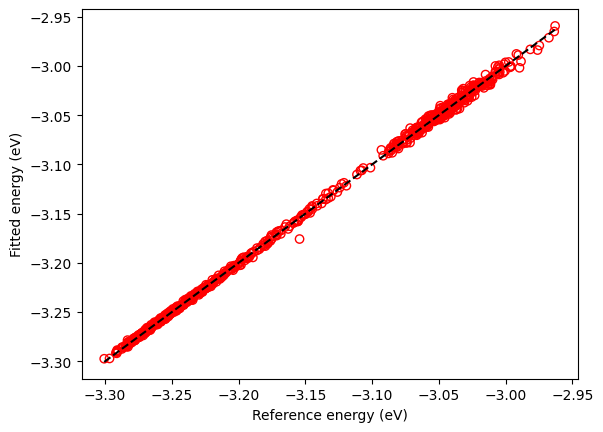

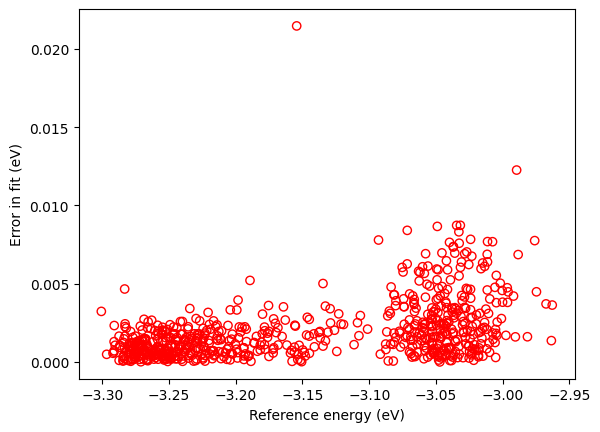

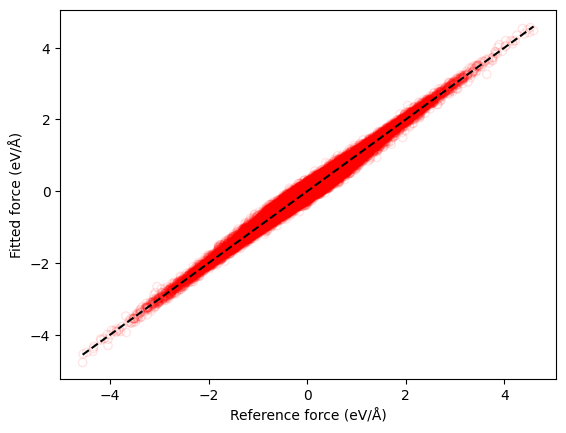

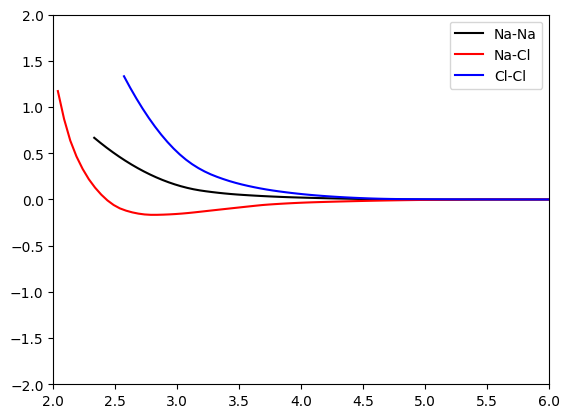

In [9]:
import numpy as np
import json
import matplotlib.pyplot as plt

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)


err=np.loadtxt("CCS_error.out")

err[:,0]=err[:,0]/err[:,3]
err[:,1]=err[:,1]/err[:,3]
err[:,2]=err[:,2]/err[:,3]

plt.xlabel('Reference energy (eV)')
plt.ylabel('Fitted energy (eV)')
plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
plt.show()
plt.xlabel('Reference energy (eV)')
plt.ylabel('Error in fit (eV)')
plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
plt.show()


err_F=np.loadtxt("CCS_error_forces.out")
plt.xlabel('Reference force (eV/Å)')
plt.ylabel('Fitted force (eV/Å)')
plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
plt.show()




plt.xlim(2,6)
plt.ylim(-2.0,2.0)
# plt.xlabel('Distance (Å)')
# plt.ylabel('Potential (eV)')
r=np.array(CCS_params["Two_body"]["Na-Na"]["r"])
NaNa=np.array(CCS_params["Two_body"]["Na-Na"]["spl_a"])
plt.plot(r,NaNa,color='black',label="Na-Na")
r=np.array(CCS_params["Two_body"]["Cl-Na"]["r"])
NaCl=np.array(CCS_params["Two_body"]["Cl-Na"]["spl_a"])
plt.plot(r,NaCl,color='red',label="Na-Cl")
r=np.array(CCS_params["Two_body"]["Cl-Cl"]["r"])
ClCl=np.array(CCS_params["Two_body"]["Cl-Cl"]["spl_a"])
plt.plot(r,ClCl,color='blue',label="Cl-Cl")

plt.legend()
plt.show()

In [10]:
from ase.lattice.cubic import FaceCenteredCubic
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from ase.io.trajectory import Trajectory
from ase.build import bulk
import json


json_file = open("CCS_params.json")
CCS_params = json.load(json_file)



atoms=bulk('NaCl','rocksalt',a=6.369976562933614,cubic=True)
atoms=atoms*[2,2,2]
charge_dict={"Na":1,"Cl":-1}

calc = CCS(CCS_params=CCS_params)
atoms.calc=calc

print("Initial energy:", atoms.get_potential_energy())

T=1174

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=T)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = Langevin(atoms, 2 * units.fs, T * units.kB, 0.1)


def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

#Equillibrate
printenergy(atoms)
for i in range(10):
    dyn.run(100)
    printenergy(atoms)

traj = Trajectory('moldyn.traj', 'w', atoms)
dyn.attach(traj.write, interval=100)


# Now run the dynamics
printenergy(atoms)
for i in range(200):
    print("STEP: ", i*100," ",end='')
    dyn.run(100)
    printenergy(atoms)

print("Final energy:", atoms.get_potential_energy())


/Users/tjams20/opt/anaconda3/envs/CCS_fit/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
/Users/tjams20/opt/anaconda3/envs/CCS_fit/lib/python3.9/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


Initial energy: -109.12864571546875
Energy per atom: Epot = -1.705eV  Ekin = 0.150eV (T=1161K)  Etot = -1.555eV
Energy per atom: Epot = -1.581eV  Ekin = 0.121eV (T=936K)  Etot = -1.460eV
Energy per atom: Epot = -1.570eV  Ekin = 0.139eV (T=1078K)  Etot = -1.431eV
Energy per atom: Epot = -1.577eV  Ekin = 0.150eV (T=1158K)  Etot = -1.427eV
Energy per atom: Epot = -1.543eV  Ekin = 0.140eV (T=1085K)  Etot = -1.403eV
Energy per atom: Epot = -1.537eV  Ekin = 0.134eV (T=1040K)  Etot = -1.402eV
Energy per atom: Epot = -1.551eV  Ekin = 0.149eV (T=1154K)  Etot = -1.401eV
Energy per atom: Epot = -1.542eV  Ekin = 0.134eV (T=1039K)  Etot = -1.408eV
Energy per atom: Epot = -1.547eV  Ekin = 0.142eV (T=1096K)  Etot = -1.406eV
Energy per atom: Epot = -1.532eV  Ekin = 0.127eV (T=985K)  Etot = -1.405eV
Energy per atom: Epot = -1.506eV  Ekin = 0.172eV (T=1331K)  Etot = -1.334eV
Energy per atom: Epot = -1.506eV  Ekin = 0.172eV (T=1331K)  Etot = -1.334eV
STEP:  0  Energy per atom: Epot = -1.514eV  Ekin = 0.1

In [11]:
# run some more

for i in range(200):
    print("STEP: ", i*100," ",end='')
    dyn.run(100)
    printenergy(atoms)

STEP:  0  Energy per atom: Epot = -1.511eV  Ekin = 0.174eV (T=1342K)  Etot = -1.337eV
STEP:  100  Energy per atom: Epot = -1.517eV  Ekin = 0.176eV (T=1363K)  Etot = -1.341eV
STEP:  200  Energy per atom: Epot = -1.531eV  Ekin = 0.144eV (T=1114K)  Etot = -1.387eV
STEP:  300  Energy per atom: Epot = -1.521eV  Ekin = 0.153eV (T=1186K)  Etot = -1.368eV
STEP:  400  Energy per atom: Epot = -1.528eV  Ekin = 0.145eV (T=1121K)  Etot = -1.383eV
STEP:  500  Energy per atom: Epot = -1.520eV  Ekin = 0.137eV (T=1057K)  Etot = -1.383eV
STEP:  600  Energy per atom: Epot = -1.505eV  Ekin = 0.140eV (T=1081K)  Etot = -1.365eV
STEP:  700  Energy per atom: Epot = -1.508eV  Ekin = 0.176eV (T=1358K)  Etot = -1.333eV
STEP:  800  Energy per atom: Epot = -1.542eV  Ekin = 0.171eV (T=1325K)  Etot = -1.370eV
STEP:  900  Energy per atom: Epot = -1.533eV  Ekin = 0.168eV (T=1299K)  Etot = -1.365eV
STEP:  1000  Energy per atom: Epot = -1.514eV  Ekin = 0.149eV (T=1151K)  Etot = -1.366eV
STEP:  1100  Energy per atom: Epo

Na Diffusion constant: 6.54586762542907e-05  cm^2/s, Standard deviation 1.0056428239975033e-05
Cl Diffusion constant: 6.496167779780611e-05  cm^2/s, Standard deviation 3.6321590407750184e-06
REFERENCE VALUES FROM GAP POTENTIALS https://pubs.acs.org/doi/full/10.1021/acs.jpcc.0c08870
Na Diffusion constant:  9.78E-5 cm^2/s, Standard deviation: 0.19E-5 
Cl Diffusion constant:  7.73E-5 cm^2/s, Standard deviation: 0.11E-5 


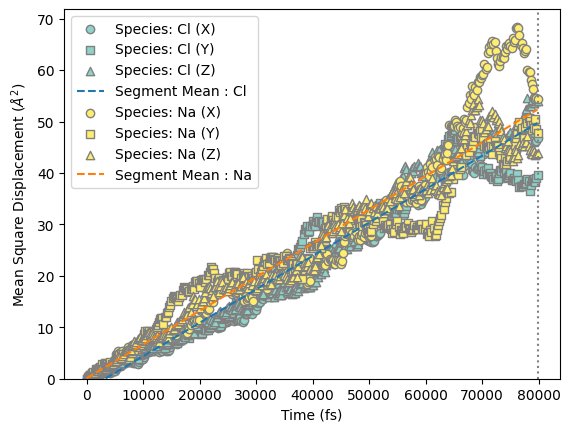

In [12]:
from ase.md.analysis import DiffusionCoefficient
from ase.io.trajectory import Trajectory
traj = Trajectory('moldyn.traj')
Df=DiffusionCoefficient(traj, 200*units.fs, atom_indices=None, molecule=False)
Df.calculate()
D=Df.get_diffusion_coefficients()
conv_factor=units.fs*0.1

print("Na Diffusion constant:", D[0][1]*conv_factor," cm^2/s, Standard deviation",D[1][1]*conv_factor)
print("Cl Diffusion constant:", D[0][0]*conv_factor," cm^2/s, Standard deviation",D[1][0]*conv_factor)


print("REFERENCE VALUES FROM GAP POTENTIALS https://pubs.acs.org/doi/full/10.1021/acs.jpcc.0c08870")

print("Na Diffusion constant:  9.78E-5 cm^2/s, Standard deviation: 0.19E-5 ")
print("Cl Diffusion constant:  7.73E-5 cm^2/s, Standard deviation: 0.11E-5 ")
Df.plot()

In [14]:
!ase -T gui moldyn.traj

Traceback (most recent call last):
  File "/usr/local/bin/ase", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/site-packages/ase/cli/main.py", line 103, in main
    f(args)
  File "/usr/local/lib/python3.10/site-packages/ase/gui/ag.py", line 98, in run
    from ase.gui.gui import GUI
  File "/usr/local/lib/python3.10/site-packages/ase/gui/gui.py", line 12, in <module>
    import ase.gui.ui as ui
  File "/usr/local/lib/python3.10/site-packages/ase/gui/ui.py", line 8, in <module>
    import tkinter as tk
  File "/usr/local/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python3.10/tkinter/__init__.py", line 37, in <module>
    import _tkinter # If this fails your Python may not be configured for Tk
ModuleNotFoundError: No module named '_tkinter'


Buckingham fit (not optimised) for element pair Cl-Cl;     V(r) = 454.10*exp(-2.24*r) -(17.89)/r^6.
Lennard Jones fit (not optimised) for element pair Cl-Cl;  V(r) = 4*-234909.76*((0.27/r)^12 - (0.27/r)^6)
Morse fit (not optimised) for element pair Cl-Cl;          V(r) = -7.06*((1-np.exp(-2.31*(r-1.58)))^2 - 1)
Pedone fit (not optimised) for element pair Cl-Cl;         V(r) = -270.58*((1-np.exp(-2.31*(r-0.01)))^2 - 1) + -7124.40/r^12


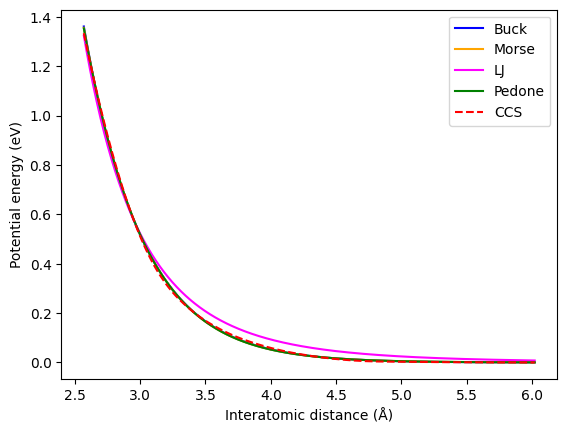

Buckingham fit (not optimised) for element pair Cl-Na;     V(r) = -52.40*exp(-1.57*r) -(-236.73)/r^6.
Lennard Jones fit (not optimised) for element pair Cl-Na;  V(r) = 4*-41869.31*((0.25/r)^12 - (0.25/r)^6)
Morse fit (not optimised) for element pair Cl-Na;          V(r) = -1.10*((1-np.exp(-9.80*(r-2.03)))^2 - 1)
Pedone fit (not optimised) for element pair Cl-Na;         V(r) = -62357.23*((1-np.exp(-5.60*(r-0.47)))^2 - 1) + -92713.52/r^12


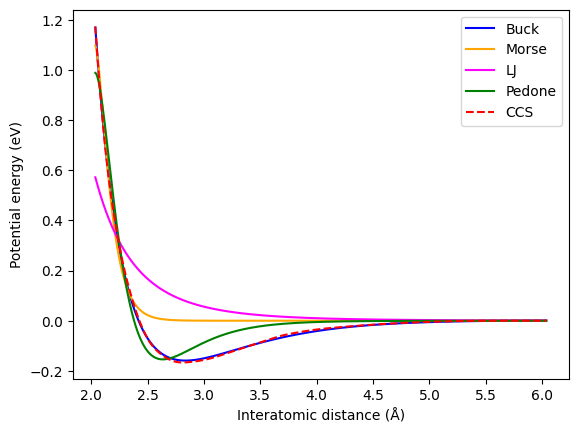

Buckingham fit (not optimised) for element pair Na-Na;     V(r) = 157.35*exp(-2.17*r) -(49.24)/r^6.
Lennard Jones fit (not optimised) for element pair Na-Na;  V(r) = 4*-2.68*((1.50/r)^12 - (1.50/r)^6)
Morse fit (not optimised) for element pair Na-Na;          V(r) = -0.89*((1-np.exp(-2.48*(r-2.05)))^2 - 1)
Pedone fit (not optimised) for element pair Na-Na;         V(r) = -133.38*((1-np.exp(-2.45*(r-0.00)))^2 - 1) + -5635.51/r^12


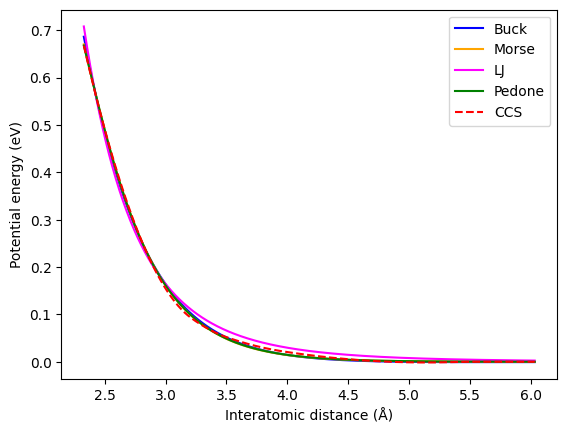

In [15]:
from ccs_fit.scripts.ccs_export_FF import write_FF
write_FF("CCS_params.json")